# Clustering

**Unsupervised learning** - not predicting, but finding patterns in data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load raw data
votes = pd.read_csv('114-congress.csv', header=1)
votes2= pd.read_csv('114-congress2.csv', header=1)
votes3= pd.read_csv('114-congress3.csv', header=1)
# add the raw data so we can have several vote results (while cleaning up column name/order)
votes.rename(columns={'vote':'vote1'}, inplace=True)
votes['vote2']=votes2['vote']
votes['vote3']=votes3['vote']
votes=votes[['person','state','party','name','vote1','vote2','vote3']]
print votes.head(5)

   person state       party                      name vote1 vote2 vote3
0  300002    TN  Republican  Sen. Lamar Alexander [R]   Nay   Yea   Yea
1  300011    CA    Democrat    Sen. Barbara Boxer [D]   Yea   Nay   Nay
2  300018    WA    Democrat   Sen. Maria Cantwell [D]   Yea   Yea   Nay
3  300019    DE    Democrat    Sen. Thomas Carper [D]   Yea   Yea   Nay
4  300023    MS  Republican     Sen. Thad Cochran [R]   Nay   Yea   Yea


In [3]:
# convert the vote column into integers for analysis
replace_dict={'Nay':0, 'Yea':1, 'Not Voting':0.5}
votes['vote1']=votes['vote1'].map(replace_dict)
votes['vote2']=votes['vote2'].map(replace_dict)
votes['vote3']=votes['vote3'].map(replace_dict)
print votes.head(5)

   person state       party                      name  vote1  vote2  vote3
0  300002    TN  Republican  Sen. Lamar Alexander [R]    0.0    1.0    1.0
1  300011    CA    Democrat    Sen. Barbara Boxer [D]    1.0    0.0    0.0
2  300018    WA    Democrat   Sen. Maria Cantwell [D]    1.0    1.0    0.0
3  300019    DE    Democrat    Sen. Thomas Carper [D]    1.0    1.0    0.0
4  300023    MS  Republican     Sen. Thad Cochran [R]    0.0    1.0    1.0


In [4]:
# Examine the distribution of party members
print votes['party'].value_counts()

# Look at the mean votes where <0.5 is against the bill and >0.5 is for bill
print np.mean(votes.iloc[:,4:])

Republican     54
Democrat       44
Independent     2
Name: party, dtype: int64
vote1    0.450
vote2    0.865
vote3    0.565
dtype: float64


## Euclidean distance : computing "closeness"

In [5]:
# import library
from sklearn.metrics.pairwise import euclidean_distances

# print the euclidean distance between the 1st and 2nd voter
print votes.iloc[0,4:]
print votes.iloc[0,4:].reshape(1,-1)
print votes.iloc[0,4:].reshape(-1,1)

print euclidean_distances(votes.iloc[0,4:].reshape(1,-1), votes.iloc[1,4:].reshape(1,-1))

vote1    0
vote2    1
vote3    1
Name: 0, dtype: object
[[0.0 1.0 1.0]]
[[0.0]
 [1.0]
 [1.0]]
[[ 1.73205081]]


## Clustering

In [10]:
# import and instantiate to cluster into two groups (R or D)
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=2, random_state=1)


#  This can be skipped because initially there was NaN in the columns that converted it to an object.
#  Without error, automatically converted to float
#
# Since the votes columns are represented as objects, need to change datatype to int/float for analysis
#print votes.dtypes
#cols=['vote1','vote2','vote3']
#votes[cols]=votes[cols].astype(float)

# Calculate senator distances from the cluster
senator_distances=kmeans_model.fit_transform(votes.iloc[:,4:])
print senator_distances[:5]

[[ 1.38041862  0.04165978]
 [ 0.72648316  1.69542408]
 [ 0.28867513  1.38232646]
 [ 0.28867513  1.38232646]
 [ 1.38041862  0.04165978]]


## Exploring the clusters using pandas.crosstab()

In [11]:
labels = kmeans_model.labels_
print labels

print pd.crosstab(labels, votes['party'])

[1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0
 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1
 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1]
party  Democrat  Independent  Republican
row_0                                   
0            41            1           3
1             3            1          51


### Exploring senators in the wrong cluster

In [15]:
democratic_outliers = votes[(labels == 1) & (votes['party']=='Democrat')]
print democratic_outliers

republican_outliers = votes[(labels == 0) & (votes['party'] == 'Republican')]
print republican_outliers

    person state     party                       name  vote1  vote2  vote3
10  300043    CA  Democrat  Sen. Dianne Feinstein [D]    0.0    1.0    0.0
53  412205    IN  Democrat      Sen. Joe Donnelly [D]    0.0    1.0    1.0
73  412391    WV  Democrat   Sen. Joe Manchin III [D]    0.5    1.0    1.0
    person state       party                name  vote1  vote2  vote3
79  412492    KY  Republican  Sen. Rand Paul [R]    1.0    0.0    1.0
82  412495    UT  Republican   Sen. Mike Lee [R]    1.0    0.5    0.5
91  412573    TX  Republican   Sen. Ted Cruz [R]    1.0    1.0    1.0


### Plotting the clusters

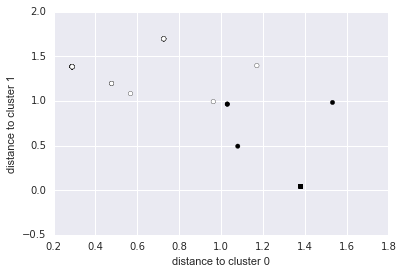

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.scatter(x=senator_distances[:,0],y=senator_distances[:,1],c=labels)
plt.xlabel('distance to cluster 0')
plt.ylabel('distance to cluster 1')
sns.plt.show()

### Finding the most extreme

In [22]:
extremism = np.sum(senator_distances**3, axis=1)
votes['extremism']=extremism
print votes.sort_values('extremism', ascending=False)[:20]

    person state        party                               name  vote1  \
44  400357    VT  Independent  Sen. Bernard “Bernie” Sanders [I]    1.0   
51  412194    CT     Democrat        Sen. Christopher Murphy [D]    1.0   
40  400253    MA     Democrat        Sen. Edward “Ed” Markey [D]    1.0   
84  412507    HI     Democrat              Sen. Brian Schatz [D]    1.0   
69  412325    OR     Democrat              Sen. Jeff Merkley [D]    1.0   
86  412542    MA     Democrat          Sen. Elizabeth Warren [D]    1.0   
15  300065    VT     Democrat             Sen. Patrick Leahy [D]    1.0   
1   300011    CA     Democrat             Sen. Barbara Boxer [D]    1.0   
29  300100    OR     Democrat                 Sen. Ron Wyden [D]    1.0   
55  412223    NY     Democrat        Sen. Kirsten Gillibrand [D]    1.0   
54  412218    NV   Republican               Sen. Dean Heller [R]    0.0   
79  412492    KY   Republican                 Sen. Rand Paul [R]    1.0   
52  412200    HI     Demo